In [391]:
# =========================================================
# SEÇÃO 1: IMPORTAÇÕES E SETUP GERAL (APENAS PARA ANÁLISE)
# =========================================================

In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from IPython.display import display, Markdown
from tqdm import tqdm

# --- Importando as funções compartilhadas necessárias ---
from helper.utils import carregar_serie, dividir_serie_temporal, calcular_metricas

In [393]:
# =========================================================
# SEÇÃO 2: FUNÇÕES DE GERAÇÃO DE RELATÓRIOS (CAMADA GOLD)
# =========================================================

In [394]:
def calcular_metricas_finais(df_results):

    modelos = [col for col in df_results.columns if col not in [
        'ds', 'y_true', 'dataset', 'horizonte']]

    y_train_dict = {}

    for dataset_nome in df_results['dataset'].unique():
        horizonte_max_ds = df_results[df_results['dataset']
                                      == dataset_nome]['horizonte'].max()
        serie_original = carregar_serie(dataset_nome)
        percentual_treino = 1 - (horizonte_max_ds / len(serie_original))
        treino, _ = dividir_serie_temporal(serie_original, percentual_treino)
        y_train_dict[dataset_nome] = treino.values

    df_melted = df_results.melt(id_vars=['ds', 'y_true', 'dataset', 'horizonte'],
                                value_vars=modelos, var_name='Modelo', value_name='y_pred')

    metricas_gerais = []

    for (dataset, horizonte, modelo), group in tqdm(df_melted.groupby(['dataset', 'horizonte', 'Modelo']), desc="Calculando Métricas"):
        if not group['y_pred'].isnull().all():

            y_train_correto = y_train_dict[dataset]

            # Calcula as métricas
            metricas_dict = calcular_metricas(
                group['y_true'], group['y_pred'], y_train_correto)

            # Adiciona as informações de metadados ao dicionário
            metricas_dict['dataset'] = dataset
            metricas_dict['horizonte'] = horizonte
            metricas_dict['Modelo'] = modelo

            metricas_gerais.append(metricas_dict)

    df_metricas_final = pd.DataFrame(metricas_gerais)
    # Renomeia colunas para clareza nos relatórios
    df_metricas_final.rename(columns={
                             'RMSE': 'Mean RMSE', 'MAPE(%)': 'Mean MAPE(%)', 'MASE': 'Mean MASE'}, inplace=True)
    return df_metricas_final

In [395]:
def plotar_evolucao_erro(df_metricas, vetor_horizontes):
    """RELATÓRIO 1: Gera o gráfico de linha da evolução do erro."""
    print("\n--- RELATÓRIO 1: EVOLUÇÃO DO ERRO (RMSE) POR HORIZONTE ---")
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_metricas, x='horizonte', y='Mean RMSE',
                 hue='Modelo', style='Modelo', markers=True, dashes=False)
    plt.title("Evolução do Erro (RMSE) com o Aumento do Horizonte", fontsize=16)
    plt.xlabel("Horizonte de Previsão")
    plt.ylabel("RMSE Médio")
    plt.grid(True)
    if not df_metricas.empty:
        plt.xticks(vetor_horizontes)
    plt.legend(title='Modelo')
    plt.show()

In [396]:
def exibir_desempenho_agregado(df_foco):
    """RELATÓRIO 2: Mostra a tabela de desempenho geral agregado."""
    print("\n--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA NO HORIZONTE MAIS LONGO) ---")
    df_agrupado = df_foco.groupby(
        'Modelo')[['Mean RMSE', 'Mean MAPE(%)', 'Mean MASE']].mean()
    display(df_agrupado.style.format('{:.3f}').highlight_min(
        axis=0, props='background-color: blue; color: white;'))

In [397]:
def exibir_desempenho_detalhado(df_foco):
    """RELATÓRIO 3: Mostra a tabela de desempenho detalhado por dataset."""
    print("--- RELATÓRIO 3: DESEMPENHO DETALHADO POR DATASET (HORIZONTE MAIS LONGO) ---")
    df_reporte_detalhado = df_foco.set_index(
        ['dataset', 'Modelo']).drop(columns=['horizonte'])
    display(df_reporte_detalhado.style.format('{:.3f}'))

In [398]:
def exibir_tabela_ranking(df_foco):
    """RELATÓRIO 4: Mostra a tabela de ranking e a retorna para uso posterior."""
    print("--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM RMSE, HORIZONTE MAIS LONGO) ---")
    df_rank = df_foco.copy()
    df_rank['Rank'] = df_rank.groupby(
        'dataset')['Mean RMSE'].rank().astype(int)
    df_pivot_rank = df_rank.pivot_table(
        index='dataset', columns='Modelo', values='Rank')
    if len(df_pivot_rank) > 1:
        df_pivot_rank.loc['Média do Rank'] = df_pivot_rank.mean(axis=0)
    display(df_pivot_rank.style.format('{:.1f}').highlight_min(
        axis=1, props='background-color: blue; color: white;'))
    return df_pivot_rank

In [399]:
def plotar_diferenca_percentual(df_foco):
    """RELATÓRIO 5: Mostra o gráfico de ganho percentual do modelo híbrido."""
    print("--- RELATÓRIO 5: GANHO PERCENTUAL DO MODELO HÍBRIDO (BASEADO EM MAPE, HORIZONTE MAIS LONGO) ---")
    df_pivot_mape = df_foco.pivot_table(
        index='dataset', columns='Modelo', values='Mean MAPE(%)')
    modelo_referencia_hibrido = 'Híbrido (MIMO)'
    if modelo_referencia_hibrido in df_pivot_mape.columns:
        mape_hibrido = df_pivot_mape[modelo_referencia_hibrido]
        df_pd = pd.DataFrame(index=df_pivot_mape.index)
        for modelo in [m for m in df_pivot_mape.columns if m != modelo_referencia_hibrido]:
            df_pd[f'Ganho sobre {modelo} (%)'] = 100 * (
                df_pivot_mape[modelo] - mape_hibrido) / df_pivot_mape[modelo]
        ax = df_pd.plot(kind='bar', figsize=(14, 7), grid=True, rot=45)
        ax.set_ylabel("Melhora Percentual (%)")
        ax.set_xlabel("Dataset")
        ax.set_title(
            f"Diferença Percentual (PD%): Ganho de Performance do {modelo_referencia_hibrido}")
        plt.tight_layout()
        plt.show()

In [400]:
# Em 02_generate_reports.ipynb

def exibir_analise_estatistica_demsar(df_pivot_rank, maior_horizonte):
    """
    Versão final da função de análise estatística, com a chamada correta para o teste post-hoc.
    """
    print("="*60)
    print(f"     RELATÓRIO 6: ANÁLISE ESTATÍSTICA GLOBAL (FRIEDMAN + NEMENYI, HORIZONTE {int(maior_horizonte)})")
    print("="*60)
    
    p_values_nemenyi = None
    avg_ranks = None
    
    df_rank_data = df_pivot_rank.drop('Média do Rank', errors='ignore')
    
    print(f"Número de datasets antes da limpeza de NaN: {len(df_rank_data)}")
    df_rank_data.dropna(inplace=True)
    print(f"Número de datasets após a limpeza de NaN: {len(df_rank_data)}")
    
    if len(df_rank_data) < 2:
        print("\nAVISO: Dados insuficientes para análise estatística após remover datasets com falhas.")
        return p_values_nemenyi, avg_ranks

    try:
        stat, p_value = friedmanchisquare(*[df_rank_data[col].values for col in df_rank_data.columns])
        print(f"\\n--- Teste de Friedman ---\\nEstatística: {stat:.3f}, p-valor: {p_value:.4f}")

        if p_value < 0.05:
            print("\\n**Conclusão: Há uma diferença estatisticamente significativa entre os modelos.**")
            print("\\n--- Teste Post-hoc de Nemenyi (p-valores par a par) ---")
            
            # =====================================================================
            # >>>>> INÍCIO DA CORREÇÃO <<<<<
            # Em vez de "derreter" o dataframe, passamos a tabela de ranks diretamente.
            # A biblioteca usará as colunas como os grupos a serem comparados.
            p_values_nemenyi = sp.posthoc_nemenyi_friedman(df_rank_data)
            # >>>>> FIM DA CORREÇÃO <<<<<
            # =====================================================================
            
            # Pega a média dos ranks, que será usada no gráfico
            avg_ranks = df_pivot_rank.loc['Média do Rank']
            
            # Mostra a tabela de p-valores, destacando os que são significativos
            display(p_values_nemenyi.style.format('{:.3f}').map(lambda x: 'background-color: blue' if x < 0.05 else ''))
        else:
            print("\\n**Conclusão: Não há evidência de uma diferença estatística significativa entre os modelos.**")
            
    except Exception as e:
        print(f"AVISO: A análise estatística avançada falhou: {e}")
        
    return p_values_nemenyi, avg_ranks

In [401]:
# Renomeamos a função para refletir o gráfico correto que ela gera
def plotar_mapa_de_significancia(p_values_nemenyi, alpha=0.05):
    if p_values_nemenyi is None:
        print("\nAVISO: O Teste de Friedman não foi estatisticamente significativo (p > 0.05).")
        print("Portanto, o mapa de significância não é aplicável.")
        return

    print("\n--- MAPA DE SIGNIFICÂNCIA (TESTE DE NEMENYI) ---")
    display(Markdown("Este mapa de calor mostra os p-valores para a comparação par-a-par. Células escuras indicam uma diferença estatisticamente significativa (p < 0.05)."))
    
    # =====================================================================
    # >>>>> CORREÇÃO FINAL APLICADA AQUI <<<<<
    # A função sign_plot é chamada apenas com a matriz de p-valores.
    # Ela gera um mapa de calor onde os pares significativos são destacados.
    sp.sign_plot(p_values_nemenyi)
    # =====================================================================
    
    plt.title(f"Mapa de Significância do Teste de Nemenyi (alpha={alpha})", fontsize=16)
    plt.show()

In [402]:
# --- NOVA FUNÇÃO DE RELATÓRIO (BASEADA NA TABELA 4 DO ARTIGO) ---
def exibir_tabela_ranking(df_foco, metrica='Mean RMSE'):
    """RELATÓRIO 4: Mostra a tabela de ranking dos modelos."""
    print(f"\n--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM {metrica}) ---")
    df_rank = df_foco.copy()
    rank_col_name = f'Rank_{metrica}'
    df_rank[rank_col_name] = df_rank.groupby(
        'dataset')[metrica].rank().astype(int)
    df_pivot_rank = df_rank.pivot_table(
        index='dataset', columns='Modelo', values=rank_col_name)
    if len(df_pivot_rank) > 1:
        df_pivot_rank.loc['Média do Rank'] = df_pivot_rank.mean(axis=0)
    display(df_pivot_rank.style.format('{:.1f}').highlight_min(
        axis=1, props='background-color: blue; color: white;'))
    return df_pivot_rank

In [403]:
def exibir_ranking_mape_artigo(df_foco):
    """RELATÓRIO EXTRA 1: Gera a tabela de ranking por MAPE, no estilo da Tabela 4 do artigo."""
    print("="*60)
    print("     RELATÓRIO ADICIONAL: TABELA DE RANKING POR MAPE (ESTILO ARTIGO)")
    print("="*60)

    df_rank_mape = df_foco.copy()
    df_rank_mape['Rank_MAPE'] = df_rank_mape.groupby(
        'dataset')['Mean MAPE(%)'].rank().astype(int)
    df_pivot = df_rank_mape.pivot_table(
        index='Modelo', columns='dataset', values='Rank_MAPE')

    # Calcula a Média e Mediana do Rank para cada modelo
    df_pivot['Média'] = df_pivot.mean(axis=1)
    df_pivot['Mediana'] = df_pivot.median(axis=1)

    def highlight_top3(s):
        is_top3 = s <= 3
        return ['background-color: blue' if v else '' for v in is_top3]

    styled_pivot = (df_pivot.style
                    .format('{:.1f}')
                    .apply(highlight_top3, subset=pd.IndexSlice[:, [c for c in df_pivot.columns if c not in ['Média', 'Mediana']]])
                    .set_caption("Ranking dos modelos por dataset baseado no MAPE (1 = Melhor)."))

    display(styled_pivot)

In [404]:
# --- NOVA FUNÇÃO DE RELATÓRIO (BASEADA NA FIGURA 9 DO ARTIGO) ---
def plotar_pd_agregado(df_foco):
    """RELATÓRIO EXTRA 2: Gera o gráfico de Diferença Percentual (PD%) agregado."""
    print("="*60)
    print("     RELATÓRIO ADICIONAL: GRÁFICO DE DIFERENÇA PERCENTUAL AGREGADO (ESTILO FIGURA 9)")
    print("="*60)

    modelo_referencia_hibrido = 'Híbrido (MIMO)'
    # Calcula o MAPE médio para cada modelo, em todos os datasets
    df_mean_mape = df_foco.groupby('Modelo')['Mean MAPE(%)'].mean()

    if modelo_referencia_hibrido in df_mean_mape.index:
        mape_hibrido = df_mean_mape[modelo_referencia_hibrido]
        pd_values = []
        for modelo, mape_medio in df_mean_mape.items():
            if modelo != modelo_referencia_hibrido:
                pd_value = 100 * (mape_medio - mape_hibrido) / mape_medio
                pd_values.append({'Modelo': modelo, 'PD(%)': pd_value})

        if pd_values:
            df_pd = pd.DataFrame(pd_values).sort_values(by='PD(%)')

            plt.figure(figsize=(14, 8))
            ax = sns.barplot(x='Modelo', y='PD(%)', data=df_pd,
                             palette='viridis', hue='Modelo', legend=False)
            ax.set_title(
                f"Diferença Percentual (PD%) Agregada do {modelo_referencia_hibrido}", fontsize=16)
            ax.set_ylabel("Melhora Percentual (%)")
            ax.set_xlabel("Modelo Competidor")
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

In [405]:
def plotar_evolucao_ranking_mape(df_metricas, vetor_horizontes):
    """
    RELATÓRIO NOVO: Gera o gráfico de linha da evolução do Ranking Médio por horizonte,
    baseado no MAPE.
    """
    print("="*60)
    print("     RELATÓRIO ADICIONAL: EVOLUÇÃO DO RANKING MÉDIO (MAPE) POR HORIZONTE")
    print("="*60)
    
    # Cria uma cópia para trabalhar com segurança
    df_rank_mape = df_metricas.copy()
    
    # Calcula o ranking baseado em MAPE para cada dataset e horizonte
    df_rank_mape['Rank_MAPE'] = df_rank_mape.groupby(['dataset', 'horizonte'])['Mean MAPE(%)'].rank()
    
    # Calcula o rank médio para cada modelo em cada horizonte, através de todos os datasets
    df_avg_rank = df_rank_mape.groupby(['horizonte', 'Modelo'])['Rank_MAPE'].mean().reset_index()
    
    plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=df_avg_rank,
        x='horizonte',
        y='Rank_MAPE',
        hue='Modelo',
        style='Modelo',
        markers=True,
        dashes=False,
        linewidth=2.5
    )
    ax.set_title("Evolução do Ranking Médio dos Modelos com o Aumento do Horizonte", fontsize=16)
    ax.set_xlabel("Horizonte de Previsão (Passos à Frente)")
    ax.set_ylabel("Ranking Médio (Menor é Melhor)")
    ax.grid(True)
    ax.set_xticks(vetor_horizontes)
    
    # Inverte o eixo Y para que o rank 1 (melhor) fique no topo, o que é mais intuitivo
    ax.invert_yaxis()
    
    # Ajusta os ticks do eixo Y para serem inteiros, se possível
    y_ticks_max = int(df_avg_rank['Rank_MAPE'].max()) + 1
    ax.set_yticks(np.arange(1, y_ticks_max))
    
    ax.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [406]:
def analisar_subconjunto_modelos(df_metricas, horizonte_foco, lista_modelos, metrica='Mean MAPE(%)'):
    """
    Executa uma análise estatística focada em um subconjunto de modelos para um horizonte específico.
    """
    print("\n" + "#"*80)
    print(f"# ANÁLISE DE SUBCONJUNTO PARA H = {horizonte_foco} (Modelos: {', '.join(lista_modelos)})")
    print("#"*80)

    # Filtra para o horizonte e os modelos desejados
    df_foco = df_metricas[(df_metricas['horizonte'] == horizonte_foco) & (df_metricas['Modelo'].isin(lista_modelos))]

    if df_foco.empty:
        print("Não foram encontrados resultados para os modelos e horizonte especificados.")
        return

    # Gera a tabela de ranking para o subconjunto
    df_pivot_rank_subset = exibir_tabela_ranking(df_foco, metrica=metrica)

    # Executa a análise estatística para o subconjunto
    p_values, avg_ranks = exibir_analise_estatistica_demsar(df_pivot_rank_subset, horizonte_foco)

In [407]:
# Em 02_generate_reports.ipynb

def exibir_tabela_mape_por_horizonte(df_metricas):
    """
    RELATÓRIO NOVO: Gera uma tabela pivô comparando o MAPE(%) dos modelos
    através dos diferentes horizontes testados, similar à Tabela 5 do artigo de referência.
    """
    print("="*60)
    print("     RELATÓRIO: DESEMPENHO MAPE(%) POR HORIZONTE DE PREVISÃO")
    print("="*60)
    
    try:
        # Usa pivot_table para transformar os dados:
        # - Modelos como linhas (index)
        # - Horizontes como colunas (columns)
        # - MAPE como os valores (values)
        df_pivot = df_metricas.pivot_table(
            index='Modelo', 
            columns='horizonte', 
            values='Mean MAPE(%)'
        )
        
        # Ordena os modelos pela performance média para facilitar a leitura
        df_pivot = df_pivot.sort_values(by=df_pivot.columns.tolist(), ascending=True)

        # Aplica estilo para facilitar a visualização
        styled_pivot = (df_pivot.style
                        .format('{:.2f}%')  # Formata os números como porcentagem
                        .highlight_min(color='blue', axis=0)  # Destaca o melhor modelo (menor erro) em cada horizonte
                        .set_caption("Tabela de comparação de MAPE(%) por horizonte"))
        
        display(styled_pivot)
        
    except Exception as e:
        print(f"Não foi possível gerar a tabela de MAPE por horizonte. Erro: {e}")

In [408]:
# =========================================================
# SEÇÃO 3: FUNÇÕES DE GERAÇÃO DE RELATÓRIOS (CAMADA GOLD)
# =========================================================

In [409]:
def gerar_suite_completa_de_relatorios(output_file):
    """
    Função principal que orquestra a geração de todos os relatórios,
    incluindo a análise separada para cada horizonte de previsão.
    """
    print("="*80); print("     INICIANDO GERAÇÃO DA SUÍTE COMPLETA DE RELATÓRIOS"); print("="*80)
    try:
        # --- 1. Carregamento e Processamento Inicial ---
        print(f"Carregando resultados do arquivo: '{output_file}'")
        df_results = pd.read_csv(output_file)
        
        print("Calculando métricas finais a partir das previsões...")
        df_metricas_final = calcular_metricas_finais(df_results)
        
        if df_metricas_final.empty:
            print("ERRO: Nenhuma métrica pôde ser calculada. Verifique o arquivo de resultados.")
            return

        # --- 2. Relatórios Gerais (que comparam todos os horizontes) ---
        vetor_horizontes_unicos = sorted(df_metricas_final['horizonte'].unique())
        
        plotar_evolucao_erro(df_metricas_final, vetor_horizontes_unicos)
        plotar_evolucao_ranking_mape(df_metricas_final, vetor_horizontes_unicos) # Chamada corrigida
        exibir_tabela_mape_por_horizonte(df_metricas_final)

        # --- 3. Loop para Análise Específica por Horizonte ---
        for h in vetor_horizontes_unicos:
            print("\n" + "#"*80)
            print(f"# ANÁLISE DETALHADA PARA O HORIZONTE H = {h}")
            print("#"*80)
            
            df_foco = df_metricas_final[df_metricas_final['horizonte'] == h]
            
            if df_foco.empty:
                print(f"Nenhum dado encontrado para o horizonte H={h}. Pulando.")
                continue

            exibir_desempenho_agregado(df_foco)
            exibir_desempenho_detalhado(df_foco)
            
            df_pivot_rank = exibir_tabela_ranking(df_foco)
            
            p_values, avg_ranks = exibir_analise_estatistica_demsar(df_pivot_rank, h)
            plotar_mapa_de_significancia(p_values)

        print("\n" + "="*80)
        print("     SUÍTE COMPLETA DE RELATÓRIOS GERADA COM SUCESSO!")
        print("="*80)

    except FileNotFoundError:
        print(f"\nERRO: Arquivo de resultados '{output_file}' não encontrado.")
    except Exception as e:
        import traceback
        print(f"Ocorreu um erro inesperado ao gerar os relatórios: {e}")
        traceback.print_exc()

In [410]:
# =========================================================
# SEÇÃO 4: EXECUÇÃO DA CAMADA GOLD
# =========================================================

     INICIANDO GERAÇÃO DA SUÍTE COMPLETA DE RELATÓRIOS
Carregando resultados do arquivo: './data/silver/resultados_completos.csv'
Calculando métricas finais a partir das previsões...


Calculando Métricas: 100%|██████████| 297/297 [00:00<00:00, 1470.45it/s]



--- RELATÓRIO 1: EVOLUÇÃO DO ERRO (RMSE) POR HORIZONTE ---


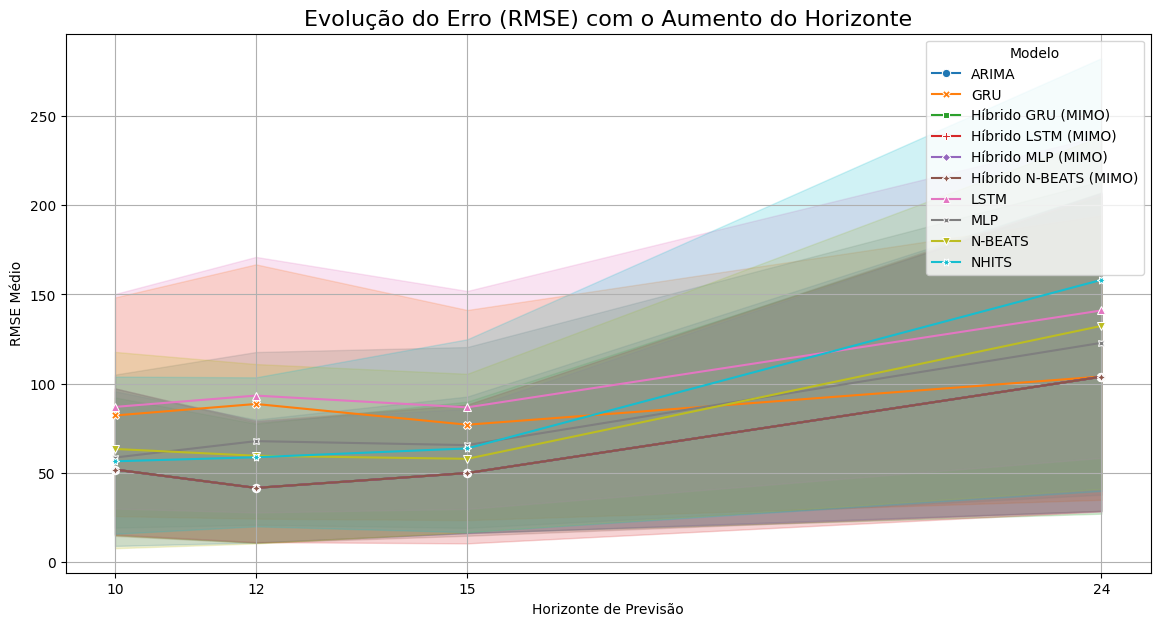

     RELATÓRIO ADICIONAL: EVOLUÇÃO DO RANKING MÉDIO (MAPE) POR HORIZONTE


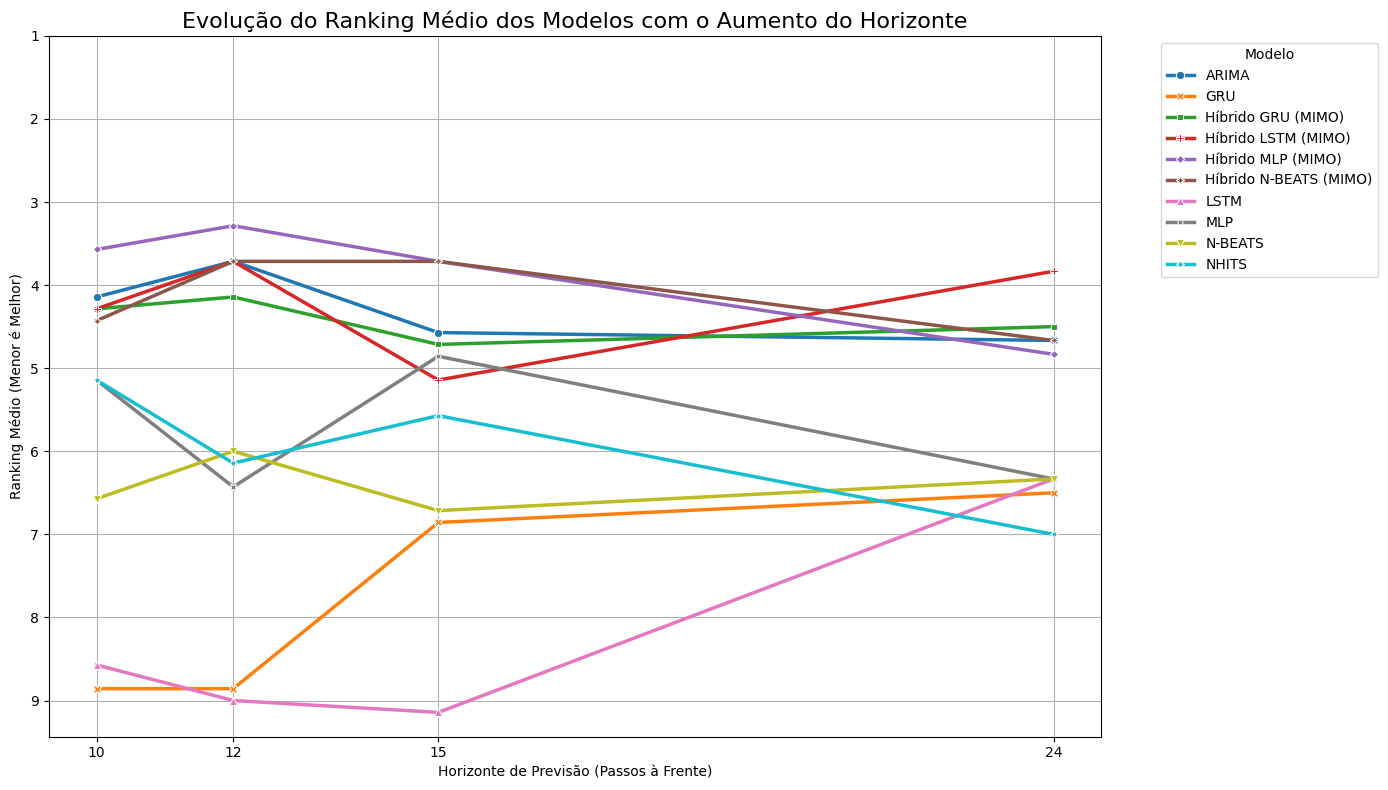

     RELATÓRIO: DESEMPENHO MAPE(%) POR HORIZONTE DE PREVISÃO


horizonte,10,12,15,24
Modelo,,,,
Híbrido GRU (MIMO),7.05%,5.89%,6.75%,10.34%
ARIMA,7.06%,5.90%,6.74%,10.34%
Híbrido MLP (MIMO),7.06%,5.90%,6.73%,10.34%
Híbrido N-BEATS (MIMO),7.07%,5.90%,6.65%,10.34%
Híbrido LSTM (MIMO),7.07%,5.88%,6.76%,10.34%
MLP,7.78%,9.06%,7.22%,12.20%
NHITS,7.88%,7.61%,7.85%,16.14%
N-BEATS,8.60%,7.94%,7.57%,13.76%
GRU,11.43%,11.93%,10.74%,10.42%



################################################################################
# ANÁLISE DETALHADA PARA O HORIZONTE H = 10
################################################################################

--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA NO HORIZONTE MAIS LONGO) ---


,Mean RMSE,Mean MAPE(%),Mean MASE
Modelo,,,
ARIMA,51.882,7.060,0.896
GRU,82.191,11.428,2.257
Híbrido GRU (MIMO),51.881,7.048,0.890
Híbrido LSTM (MIMO),51.875,7.075,0.898
Híbrido MLP (MIMO),51.881,7.062,0.897
Híbrido N-BEATS (MIMO),51.896,7.068,0.896
LSTM,86.980,13.588,2.847
MLP,58.620,7.779,1.144
N-BEATS,63.422,8.597,1.123


--- RELATÓRIO 3: DESEMPENHO DETALHADO POR DATASET (HORIZONTE MAIS LONGO) ---



--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM Mean RMSE) ---


Modelo,ARIMA,GRU,Híbrido GRU (MIMO),Híbrido LSTM (MIMO),Híbrido MLP (MIMO),Híbrido N-BEATS (MIMO),LSTM,MLP,N-BEATS,NHITS
dataset,,,,,,,,,,
AirPassengers,5.0,9.0,3.0,4.0,1.0,2.0,10.0,8.0,6.0,7.0
JohnsonJohnson,2.0,9.0,1.0,5.0,3.0,4.0,10.0,7.0,8.0,6.0
Nile,4.0,10.0,6.0,2.0,3.0,5.0,9.0,1.0,8.0,7.0
UKgas,5.0,9.0,2.0,1.0,3.0,6.0,10.0,8.0,4.0,7.0
co2,6.0,9.0,7.0,8.0,4.0,5.0,10.0,2.0,3.0,1.0
nottem,6.0,2.0,3.0,4.0,5.0,7.0,1.0,10.0,8.0,9.0
ukdriverdeaths,1.0,10.0,3.0,2.0,5.0,4.0,9.0,7.0,8.0,6.0
Média do Rank,4.1,8.3,3.6,3.7,3.4,4.7,8.4,6.1,6.4,6.1


     RELATÓRIO 6: ANÁLISE ESTATÍSTICA GLOBAL (FRIEDMAN + NEMENYI, HORIZONTE 10)
Número de datasets antes da limpeza de NaN: 7
Número de datasets após a limpeza de NaN: 7
\n--- Teste de Friedman ---\nEstatística: 24.195, p-valor: 0.0040
\n**Conclusão: Há uma diferença estatisticamente significativa entre os modelos.**
\n--- Teste Post-hoc de Nemenyi (p-valores par a par) ---


,ARIMA,GRU,Híbrido GRU (MIMO),Híbrido LSTM (MIMO),Híbrido MLP (MIMO),Híbrido N-BEATS (MIMO),LSTM,MLP,N-BEATS,NHITS
ARIMA,1.000,0.237,1.000,1.000,1.000,1.000,0.195,0.967,0.924,0.967
GRU,0.237,1.000,0.102,0.128,0.080,0.452,1.000,0.948,0.980,0.948
Híbrido GRU (MIMO),1.000,0.102,1.000,1.000,1.000,0.999,0.080,0.854,0.757,0.854
Híbrido LSTM (MIMO),1.000,0.128,1.000,1.000,1.000,1.000,0.102,0.892,0.809,0.892
Híbrido MLP (MIMO),1.000,0.080,1.000,1.000,1.000,0.999,0.062,0.809,0.700,0.809
Híbrido N-BEATS (MIMO),1.000,0.452,0.999,1.000,0.999,1.000,0.392,0.997,0.988,0.997
LSTM,0.195,1.000,0.080,0.102,0.062,0.392,1.000,0.924,0.967,0.924
MLP,0.967,0.948,0.854,0.892,0.809,0.997,0.924,1.000,1.000,1.000
N-BEATS,0.924,0.980,0.757,0.809,0.700,0.988,0.967,1.000,1.000,1.000
NHITS,0.967,0.948,0.854,0.892,0.809,0.997,0.924,1.000,1.000,1.000



--- MAPA DE SIGNIFICÂNCIA (TESTE DE NEMENYI) ---


Este mapa de calor mostra os p-valores para a comparação par-a-par. Células escuras indicam uma diferença estatisticamente significativa (p < 0.05).

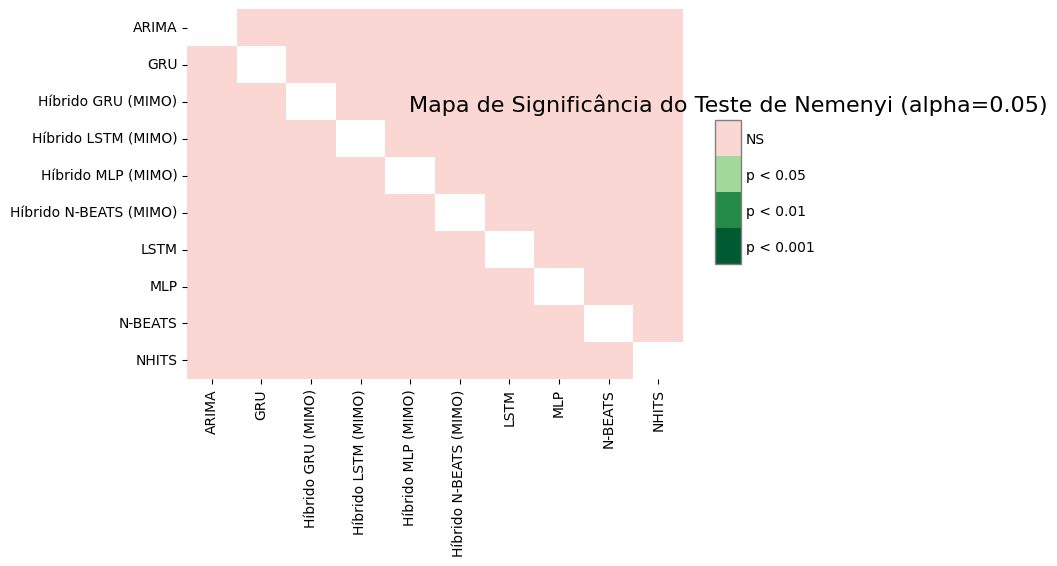


################################################################################
# ANÁLISE DETALHADA PARA O HORIZONTE H = 12
################################################################################

--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA NO HORIZONTE MAIS LONGO) ---


,Mean RMSE,Mean MAPE(%),Mean MASE
Modelo,,,
ARIMA,41.615,5.903,0.824
GRU,88.621,11.930,2.408
Híbrido GRU (MIMO),41.619,5.886,0.818
Híbrido LSTM (MIMO),41.615,5.880,0.818
Híbrido MLP (MIMO),41.618,5.905,0.824
Híbrido N-BEATS (MIMO),41.615,5.899,0.819
LSTM,93.315,12.668,2.762
MLP,67.803,9.059,1.231
N-BEATS,59.627,7.943,1.024


--- RELATÓRIO 3: DESEMPENHO DETALHADO POR DATASET (HORIZONTE MAIS LONGO) ---



--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM Mean RMSE) ---


Modelo,ARIMA,GRU,Híbrido GRU (MIMO),Híbrido LSTM (MIMO),Híbrido MLP (MIMO),Híbrido N-BEATS (MIMO),LSTM,MLP,N-BEATS,NHITS
dataset,,,,,,,,,,
AirPassengers,4.0,9.0,2.0,3.0,1.0,5.0,10.0,8.0,7.0,6.0
JohnsonJohnson,3.0,10.0,4.0,2.0,5.0,1.0,9.0,8.0,7.0,6.0
Nile,4.0,9.0,5.0,6.0,3.0,2.0,10.0,1.0,8.0,7.0
UKgas,2.0,7.0,4.0,5.0,6.0,3.0,8.0,10.0,1.0,9.0
co2,6.0,9.0,4.0,8.0,5.0,7.0,10.0,3.0,2.0,1.0
nottem,3.0,7.0,5.0,2.0,1.0,4.0,6.0,8.0,10.0,9.0
ukdriverdeaths,2.0,9.0,4.0,1.0,3.0,5.0,10.0,7.0,8.0,6.0
Média do Rank,3.4,8.6,4.0,3.9,3.4,3.9,9.0,6.4,6.1,6.3


     RELATÓRIO 6: ANÁLISE ESTATÍSTICA GLOBAL (FRIEDMAN + NEMENYI, HORIZONTE 12)
Número de datasets antes da limpeza de NaN: 7
Número de datasets após a limpeza de NaN: 7
\n--- Teste de Friedman ---\nEstatística: 30.397, p-valor: 0.0004
\n**Conclusão: Há uma diferença estatisticamente significativa entre os modelos.**
\n--- Teste Post-hoc de Nemenyi (p-valores par a par) ---


,ARIMA,GRU,Híbrido GRU (MIMO),Híbrido LSTM (MIMO),Híbrido MLP (MIMO),Híbrido N-BEATS (MIMO),LSTM,MLP,N-BEATS,NHITS
ARIMA,1.000,0.048,1.000,1.000,1.000,1.000,0.020,0.700,0.809,0.757
GRU,0.048,1.000,0.128,0.102,0.048,0.102,1.000,0.948,0.892,0.924
Híbrido GRU (MIMO),1.000,0.128,1.000,1.000,1.000,1.000,0.062,0.892,0.948,0.924
Híbrido LSTM (MIMO),1.000,0.102,1.000,1.000,1.000,1.000,0.048,0.854,0.924,0.892
Híbrido MLP (MIMO),1.000,0.048,1.000,1.000,1.000,1.000,0.020,0.700,0.809,0.757
Híbrido N-BEATS (MIMO),1.000,0.102,1.000,1.000,1.000,1.000,0.048,0.854,0.924,0.892
LSTM,0.020,1.000,0.062,0.048,0.020,0.048,1.000,0.854,0.757,0.809
MLP,0.700,0.948,0.892,0.854,0.700,0.854,0.854,1.000,1.000,1.000
N-BEATS,0.809,0.892,0.948,0.924,0.809,0.924,0.757,1.000,1.000,1.000
NHITS,0.757,0.924,0.924,0.892,0.757,0.892,0.809,1.000,1.000,1.000



--- MAPA DE SIGNIFICÂNCIA (TESTE DE NEMENYI) ---


Este mapa de calor mostra os p-valores para a comparação par-a-par. Células escuras indicam uma diferença estatisticamente significativa (p < 0.05).

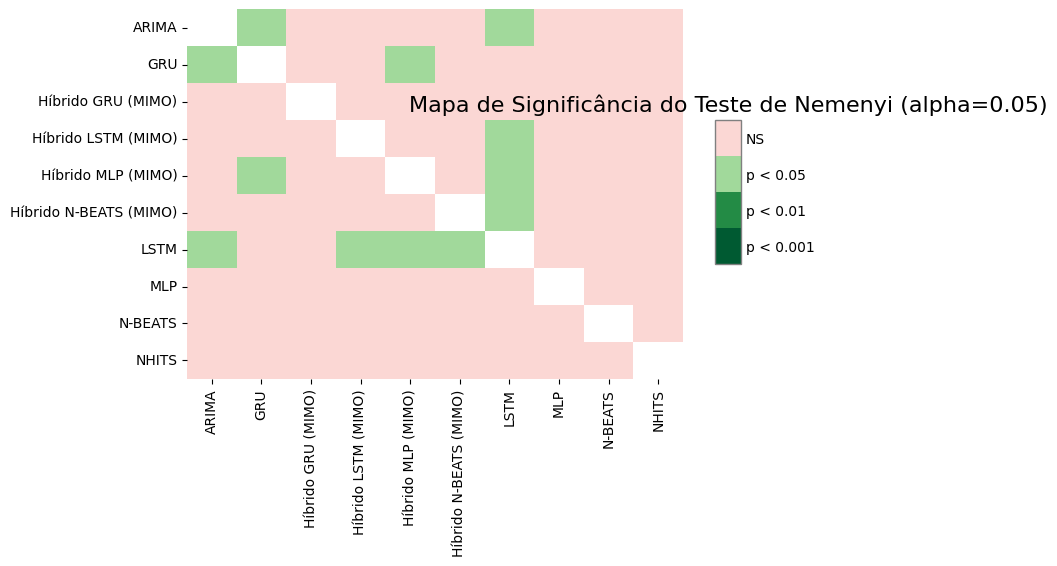


################################################################################
# ANÁLISE DETALHADA PARA O HORIZONTE H = 15
################################################################################

--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA NO HORIZONTE MAIS LONGO) ---


,Mean RMSE,Mean MAPE(%),Mean MASE
Modelo,,,
ARIMA,49.939,6.736,0.895
GRU,76.993,10.745,2.123
Híbrido GRU (MIMO),49.933,6.750,0.900
Híbrido LSTM (MIMO),49.936,6.757,0.903
Híbrido MLP (MIMO),49.930,6.730,0.895
Híbrido N-BEATS (MIMO),49.934,6.654,0.870
LSTM,86.719,11.963,2.529
MLP,65.588,7.218,0.963
N-BEATS,57.896,7.571,0.905


--- RELATÓRIO 3: DESEMPENHO DETALHADO POR DATASET (HORIZONTE MAIS LONGO) ---



--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM Mean RMSE) ---


Modelo,ARIMA,GRU,Híbrido GRU (MIMO),Híbrido LSTM (MIMO),Híbrido MLP (MIMO),Híbrido N-BEATS (MIMO),LSTM,MLP,N-BEATS,NHITS
dataset,,,,,,,,,,
AirPassengers,4.0,9.0,6.0,5.0,3.0,2.0,10.0,8.0,7.0,1.0
JohnsonJohnson,5.0,10.0,6.0,8.0,4.0,3.0,9.0,2.0,1.0,7.0
Nile,4.0,10.0,5.0,6.0,2.0,3.0,9.0,7.0,8.0,1.0
UKgas,7.0,3.0,4.0,5.0,6.0,8.0,9.0,10.0,1.0,2.0
co2,2.0,9.0,5.0,6.0,4.0,3.0,10.0,7.0,8.0,1.0
nottem,6.0,1.0,4.0,5.0,3.0,2.0,8.0,9.0,7.0,10.0
ukdriverdeaths,3.0,9.0,4.0,2.0,1.0,5.0,10.0,7.0,6.0,8.0
Média do Rank,4.4,7.3,4.9,5.3,3.3,3.7,9.3,7.1,5.4,4.3


     RELATÓRIO 6: ANÁLISE ESTATÍSTICA GLOBAL (FRIEDMAN + NEMENYI, HORIZONTE 15)
Número de datasets antes da limpeza de NaN: 7
Número de datasets após a limpeza de NaN: 7
\n--- Teste de Friedman ---\nEstatística: 23.977, p-valor: 0.0043
\n**Conclusão: Há uma diferença estatisticamente significativa entre os modelos.**
\n--- Teste Post-hoc de Nemenyi (p-valores par a par) ---


,ARIMA,GRU,Híbrido GRU (MIMO),Híbrido LSTM (MIMO),Híbrido MLP (MIMO),Híbrido N-BEATS (MIMO),LSTM,MLP,N-BEATS,NHITS
ARIMA,1.000,0.757,1.000,1.000,0.999,1.000,0.080,0.809,1.000,1.000
GRU,0.757,1.000,0.892,0.967,0.284,0.452,0.967,1.000,0.980,0.700
Híbrido GRU (MIMO),1.000,0.892,1.000,1.000,0.994,0.999,0.159,0.924,1.000,1.000
Híbrido LSTM (MIMO),1.000,0.967,1.000,1.000,0.967,0.994,0.284,0.980,1.000,1.000
Híbrido MLP (MIMO),0.999,0.284,0.994,0.967,1.000,1.000,0.008,0.336,0.948,1.000
Híbrido N-BEATS (MIMO),1.000,0.452,0.999,0.994,1.000,1.000,0.020,0.514,0.988,1.000
LSTM,0.080,0.967,0.159,0.284,0.008,0.020,1.000,0.948,0.336,0.062
MLP,0.809,1.000,0.924,0.980,0.336,0.514,0.948,1.000,0.988,0.757
N-BEATS,1.000,0.980,1.000,1.000,0.948,0.988,0.336,0.988,1.000,0.999
NHITS,1.000,0.700,1.000,1.000,1.000,1.000,0.062,0.757,0.999,1.000



--- MAPA DE SIGNIFICÂNCIA (TESTE DE NEMENYI) ---


Este mapa de calor mostra os p-valores para a comparação par-a-par. Células escuras indicam uma diferença estatisticamente significativa (p < 0.05).

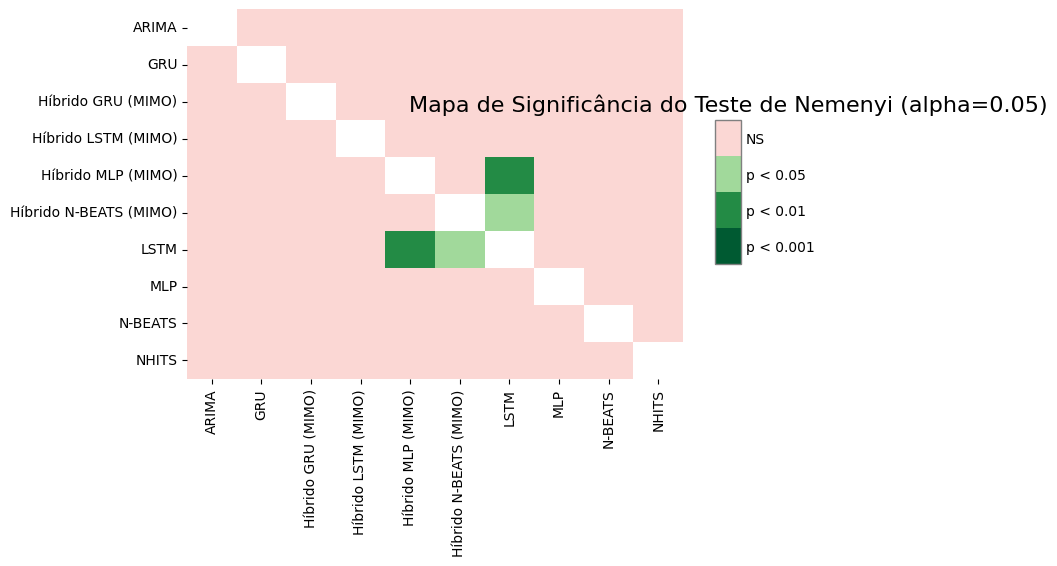


################################################################################
# ANÁLISE DETALHADA PARA O HORIZONTE H = 24
################################################################################

--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA NO HORIZONTE MAIS LONGO) ---


,Mean RMSE,Mean MAPE(%),Mean MASE
Modelo,,,
ARIMA,103.887,10.342,1.012
GRU,103.992,10.420,1.562
Híbrido GRU (MIMO),103.879,10.340,1.012
Híbrido LSTM (MIMO),103.878,10.339,1.011
Híbrido MLP (MIMO),103.882,10.340,1.012
Híbrido N-BEATS (MIMO),103.869,10.340,1.012
LSTM,140.992,14.927,2.656
MLP,122.853,12.204,1.058
N-BEATS,132.330,13.765,1.062


--- RELATÓRIO 3: DESEMPENHO DETALHADO POR DATASET (HORIZONTE MAIS LONGO) ---



--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM Mean RMSE) ---


Modelo,ARIMA,GRU,Híbrido GRU (MIMO),Híbrido LSTM (MIMO),Híbrido MLP (MIMO),Híbrido N-BEATS (MIMO),LSTM,MLP,N-BEATS,NHITS
dataset,,,,,,,,,,
AirPassengers,6.0,9.0,4.0,5.0,7.0,8.0,10.0,3.0,1.0,2.0
Nile,2.0,6.0,5.0,3.0,4.0,1.0,7.0,8.0,9.0,10.0
UKgas,6.0,1.0,5.0,4.0,3.0,2.0,8.0,9.0,7.0,10.0
co2,2.0,9.0,5.0,4.0,1.0,3.0,10.0,8.0,6.0,7.0
nottem,5.0,7.0,4.0,2.0,3.0,6.0,1.0,9.0,8.0,10.0
ukdriverdeaths,7.0,2.0,6.0,5.0,8.0,9.0,3.0,1.0,4.0,10.0
Média do Rank,4.7,5.7,4.8,3.8,4.3,4.8,6.5,6.3,5.8,8.2


     RELATÓRIO 6: ANÁLISE ESTATÍSTICA GLOBAL (FRIEDMAN + NEMENYI, HORIZONTE 24)
Número de datasets antes da limpeza de NaN: 6
Número de datasets após a limpeza de NaN: 6
\n--- Teste de Friedman ---\nEstatística: 9.600, p-valor: 0.3838
\n**Conclusão: Não há evidência de uma diferença estatística significativa entre os modelos.**

AVISO: O Teste de Friedman não foi estatisticamente significativo (p > 0.05).
Portanto, o mapa de significância não é aplicável.

     SUÍTE COMPLETA DE RELATÓRIOS GERADA COM SUCESSO!


In [411]:
silver_layer_file = "./data/silver/resultados_completos.csv"
VETOR_DE_HORIZONTES = [10, 12, 15, 24]

gerar_suite_completa_de_relatorios(silver_layer_file)